# IMDB movie review sentiment classification with BERT finetuning

In this notebook, we'll use a pre-trained [BERT](https://arxiv.org/abs/1810.04805) model for text classification using PyTorch and [PyTorch-Transformers](https://github.com/huggingface/pytorch-transformers). This notebook is based on ["Predicting Movie Review Sentiment with BERT on TF Hub"](https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb) by Google and ["BERT Fine-Tuning Tutorial with PyTorch"](https://mccormickml.com/2019/07/22/BERT-fine-tuning/) by Chris McCormick.

**Note that using a GPU with this notebook is highly recommended.**

First, the needed imports.

In [1]:
%matplotlib inline

import torch
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)
from keras.preprocessing.sequence import pad_sequences

from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import BertForSequenceClassification
from pytorch_transformers import AdamW, WarmupLinearSchedule

from distutils.version import LooseVersion as LV

from sklearn.model_selection import train_test_split

import io

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

if torch.cuda.is_available():
    device = torch.device('cuda')
    devicename = '['+torch.cuda.get_device_name(0)+']'
else:
    device = torch.device('cpu')
    devicename = ""
    
print('Using PyTorch version:', torch.__version__,
      'Device:', device, devicename)
assert(LV(torch.__version__) >= LV("1.0.0"))

Using TensorFlow backend.


Using PyTorch version: 1.1.0 Device: cuda [Tesla P100-PCIE-16GB]


## IMDB data set

We'll use the [raw version of the IMDB dataset](http://ai.stanford.edu/~amaas/data/sentiment/). 
For convenience, the IMDB training and test sets has in advance been converted to Pandas DataFrames.

First time we may have to download the data, which can take a while.

The ground truth consists of binary sentiments for each review: positive (1) or negative (0).

In [2]:
train_df = pd.read_pickle("imdb-train.pkl")
test_df  = pd.read_pickle("imdb-test.pkl")

# possibly reduce the amount of training data:
#train_df = train_df.sample(5000)

print('IMDB data loaded:')
print('train:', train_df.shape)
print('test:', test_df.shape)

IMDB data loaded:
train: (25000, 3)
test: (25000, 3)


Let's view some random training reviews:

In [3]:
train_df.sample(10)

,sentence,sentiment,polarity
14745,i really loved this version of Emma the best. ...,8,1
6039,I watched this movie with some friends a coupl...,1,0
11244,Saw this in the theater in '86 and fell out of...,10,1
24253,Most who go to this movie will have an idea wh...,7,1
20410,this film takes you inside itself in the early...,9,1
2056,Some saying about 'The Play is the Most Import...,10,1
16521,This is one of the best made movies from 2002....,9,1
5600,I would have left the movie halfway through if...,1,0
4965,I really enjoyed this movie. Most of the revie...,10,1
10953,The world is made up two different types of mo...,10,1


The reviews, i.e, our input data, are in the *sentence* column and the labels in the *polarity* column.

The token `[CLS]` is a special token required by BERT at the beginning of the sentence.

In [4]:
sentences_train = train_df.sentence.values
sentences_train = ["[CLS] " + s for s in sentences_train]

sentences_test = test_df.sentence.values
sentences_test = ["[CLS] " + s for s in sentences_test]

labels_train = train_df.polarity.values
labels_test  = test_df.polarity.values

print ("The first training sentence:")
print(sentences_train[0], 'LABEL:', labels_train[0])

The first training sentence:
[CLS] i wasn't a fan of seeing this movie at all, but when my gf called me and said she had a free advanced screening pass i tagged along only for the sake of seeing eva longoria and laughing at jason biggs antics.<br /><br />overall it was actually better then i expected but not by much. this was like a hybrid of how to lose a guy in 10 days and just like heaven. a typical romantic comedy with its moments i guess. the movie was quite short though (around 85 min.) but it was enough to tell the whole story, build some character development and have a decent happy ending. the whole idea of a ghost haunting its former husband was a interesting plot to follow. eva did a good job of keeping up the sarcasm and paul rudd and the rest of the supporting cast (especially jason biggs) kept the laughs coming at a smooth pace.<br /><br />overall i liked the movie only because it had a good amount of laughs to keep me going otherwise i would have given this movie a lower

Next we use the BERT tokenizer to convert the sentences into tokens that match the data BERT was trained on.

In [5]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',
                                          do_lower_case=True)

tokenized_train = [tokenizer.tokenize(s) for s in sentences_train]
tokenized_test  = [tokenizer.tokenize(s) for s in sentences_test]

print ("The tokenized first training sentence:")
print (tokenized_train[0])

The tokenized first training sentence:
['[CLS]', 'i', 'wasn', "'", 't', 'a', 'fan', 'of', 'seeing', 'this', 'movie', 'at', 'all', ',', 'but', 'when', 'my', 'g', '##f', 'called', 'me', 'and', 'said', 'she', 'had', 'a', 'free', 'advanced', 'screening', 'pass', 'i', 'tagged', 'along', 'only', 'for', 'the', 'sake', 'of', 'seeing', 'eva', 'long', '##oria', 'and', 'laughing', 'at', 'jason', 'big', '##gs', 'antics', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'overall', 'it', 'was', 'actually', 'better', 'then', 'i', 'expected', 'but', 'not', 'by', 'much', '.', 'this', 'was', 'like', 'a', 'hybrid', 'of', 'how', 'to', 'lose', 'a', 'guy', 'in', '10', 'days', 'and', 'just', 'like', 'heaven', '.', 'a', 'typical', 'romantic', 'comedy', 'with', 'its', 'moments', 'i', 'guess', '.', 'the', 'movie', 'was', 'quite', 'short', 'though', '(', 'around', '85', 'min', '.', ')', 'but', 'it', 'was', 'enough', 'to', 'tell', 'the', 'whole', 'story', ',', 'build', 'some', 'character', 'development', 'and', 'ha

Now we set the maximum sequence lengths for our training and test sentences as `MAX_LEN_TRAIN` and `MAX_LEN_TEST`. The maximum length supported by the used BERT model is 512.

The token `[SEP]` is another special token required by BERT at the end of the sentence.

In [6]:
MAX_LEN_TRAIN, MAX_LEN_TEST = 128, 512

tokenized_train = [t[:(MAX_LEN_TRAIN-1)]+['SEP'] for t in tokenized_train]
tokenized_test  = [t[:(MAX_LEN_TEST-1)]+['SEP'] for t in tokenized_test]

print ("The tokenized first training sentence:")
print (tokenized_train[0])

The tokenized first training sentence:
['[CLS]', 'i', 'wasn', "'", 't', 'a', 'fan', 'of', 'seeing', 'this', 'movie', 'at', 'all', ',', 'but', 'when', 'my', 'g', '##f', 'called', 'me', 'and', 'said', 'she', 'had', 'a', 'free', 'advanced', 'screening', 'pass', 'i', 'tagged', 'along', 'only', 'for', 'the', 'sake', 'of', 'seeing', 'eva', 'long', '##oria', 'and', 'laughing', 'at', 'jason', 'big', '##gs', 'antics', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'overall', 'it', 'was', 'actually', 'better', 'then', 'i', 'expected', 'but', 'not', 'by', 'much', '.', 'this', 'was', 'like', 'a', 'hybrid', 'of', 'how', 'to', 'lose', 'a', 'guy', 'in', '10', 'days', 'and', 'just', 'like', 'heaven', '.', 'a', 'typical', 'romantic', 'comedy', 'with', 'its', 'moments', 'i', 'guess', '.', 'the', 'movie', 'was', 'quite', 'short', 'though', '(', 'around', '85', 'min', '.', ')', 'but', 'it', 'was', 'enough', 'to', 'tell', 'the', 'whole', 'story', ',', 'build', 'some', 'character', 'development', 'and', 'SE

Next we use the BERT tokenizer to convert each token into an integer index in the BERT vocabulary. We also pad any shorter sequences to `MAX_LEN_TRAIN` or `MAX_LEN_TEST` indices with trailing zeros.

In [ ]:
ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(t) for t in tokenized_train],
                          maxlen=MAX_LEN_TRAIN, dtype="long", truncating="post", padding="post")
ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(t) for t in tokenized_test],
                         maxlen=MAX_LEN_TEST, dtype="long", truncating="post", padding="post")

print ("The indices of the first training sentence:")
print (ids_train[0])

BERT also requires *attention masks*, with 1 for each real token in the sequences and 0 for the padding:   

In [8]:
amasks_train, amasks_test = [], []

for seq in ids_train:
  seq_mask = [float(i>0) for i in seq]
  amasks_train.append(seq_mask)
    
for seq in ids_test:
  seq_mask = [float(i>0) for i in seq]
  amasks_test.append(seq_mask)

We use scikit-learn's `train_test_split` to use 10% of our training data as a validation set, and then convert all data into `torch.tensor`s.

In [9]:
(train_inputs, validation_inputs, 
 train_labels, validation_labels) = train_test_split(ids_train, labels_train, 
                                                     random_state=42,
                                                     test_size=0.1)
(train_masks, validation_masks, 
 _, _) = train_test_split(amasks_train, ids_train,
                          random_state=42, test_size=0.1)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks  = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks  = torch.tensor(validation_masks)
test_inputs = torch.tensor(ids_test)
test_labels = torch.tensor(labels_test)
test_masks  = torch.tensor(amasks_test)

Next we create PyTorch *DataLoader*s for all data sets. 

For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

In [10]:
BATCH_SIZE = 32

print('Train: ', end="")
train_data = TensorDataset(train_inputs, train_masks,
                           train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, 
                              batch_size=BATCH_SIZE)
print(len(train_data), 'reviews')

print('Validation: ', end="")
validation_data = TensorDataset(validation_inputs, validation_masks,
                                validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data,
                                   sampler=validation_sampler,
                                   batch_size=BATCH_SIZE)
print(len(validation_data), 'reviews')

print('Test: ', end="")
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=BATCH_SIZE)
print(len(test_data), 'reviews')

Train: 22500 reviews
Validation: 2500 reviews
Test: 25000 reviews


## BERT model initialization

We now load a pretrained BERT model with a single linear classification layer added on top. 

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                      num_labels=2)
model.cuda()

We set the remaining hyperparameters needed for fine-tuning the pretrained model:
  * `EPOCHS`: the number of training epochs in fine-tuning (recommended values between 2 and 4)
  * `WEIGHT_DECAY`: weight decay for the Adam optimizer
  * `LR`: learning rate for the Adam optimizer (2e-5 to 5e-5 recommended)
  * `WARMUP_STEPS`: number of warmup steps to (linearly) reach the set learning rate 
  
We also need to grab the training parameters from the pretrained model.

In [61]:
EPOCHS = 4
WEIGHT_DECAY = 0.01 
LR = 2e-5
WARMUP_STEPS =int(0.2*len(train_dataloader))

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
     'weight_decay': WEIGHT_DECAY},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
     'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, eps=1e-8)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=WARMUP_STEPS,
                                 t_total=len(train_dataloader)*EPOCHS)

In [62]:
def train(epoch, loss_vector=None, log_interval=200):
  # Set model to training mode
  model.train()
  
  # Loop over each batch from the training set
  for step, batch in enumerate(train_dataloader):

    # Copy data to GPU if needed
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # Zero gradient buffers
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, 
                    attention_mask=b_input_mask, labels=b_labels)

    loss = outputs[0]
    if loss_vector is not None:
        loss_vector.append(loss.item())
    
    # Backward pass
    loss.backward()
    
    # Update weights
    scheduler.step()
    optimizer.step()
    
    if step % log_interval == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, step * len(b_input_ids),
                len(train_dataloader.dataset),
                100. * step / len(train_dataloader), loss))    

In [63]:
def evaluate(loader):
  model.eval()

  n_correct, n_all = 0, 0
    
  for batch in loader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)
      logits = outputs[0]
    
    logits = logits.detach().cpu().numpy()
    predictions = np.argmax(logits, axis=1)

    labels = b_labels.to('cpu').numpy()
    n_correct += np.sum(predictions == labels)
    n_all += len(labels)
    
  print('Accuracy: [{}/{}] {:.4f}\n'.format(n_correct, n_all, n_correct/n_all))

In [64]:
%%time

train_lossv = []
for epoch in range(1, EPOCHS + 1):
    train(epoch, train_lossv)
    print('\nValidation set:')
    evaluate(validation_dataloader)

Train Epoch: 1 [0/22500 (0%)]	Loss: 0.699508
Train Epoch: 1 [6400/22500 (28%)]	Loss: 0.253407
Train Epoch: 1 [12800/22500 (57%)]	Loss: 0.417832
Train Epoch: 1 [19200/22500 (85%)]	Loss: 0.255559

Validation set:
Accuracy: [2180/2500] 0.8720

Train Epoch: 2 [0/22500 (0%)]	Loss: 0.198932
Train Epoch: 2 [6400/22500 (28%)]	Loss: 0.265345
Train Epoch: 2 [12800/22500 (57%)]	Loss: 0.341248
Train Epoch: 2 [19200/22500 (85%)]	Loss: 0.146564

Validation set:
Accuracy: [2191/2500] 0.8764

Train Epoch: 3 [0/22500 (0%)]	Loss: 0.122537
Train Epoch: 3 [6400/22500 (28%)]	Loss: 0.074572
Train Epoch: 3 [12800/22500 (57%)]	Loss: 0.084266
Train Epoch: 3 [19200/22500 (85%)]	Loss: 0.087106

Validation set:
Accuracy: [2191/2500] 0.8764

Train Epoch: 4 [0/22500 (0%)]	Loss: 0.015811
Train Epoch: 4 [6400/22500 (28%)]	Loss: 0.010665
Train Epoch: 4 [12800/22500 (57%)]	Loss: 0.126329
Train Epoch: 4 [19200/22500 (85%)]	Loss: 0.127962

Validation set:
Accuracy: [2191/2500] 0.8764

CPU times: user 17min 6s, sys: 5min 

Let's take a look at our training loss over all batches:

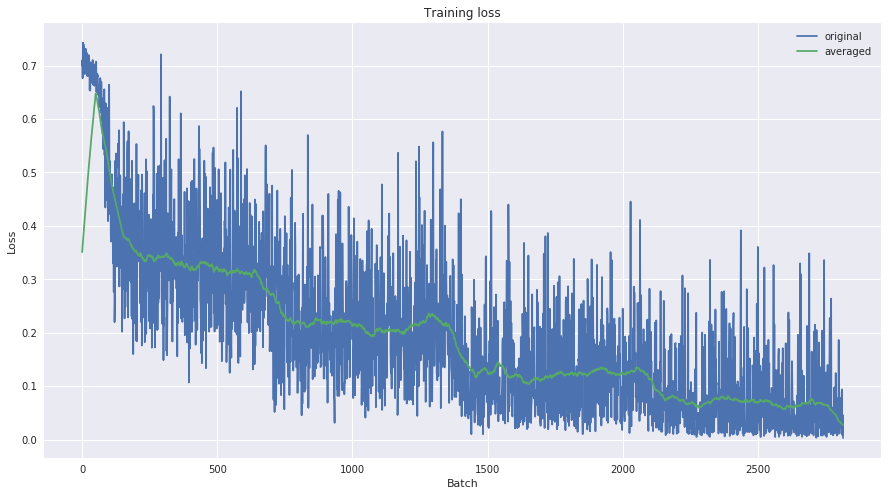

In [65]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_lossv, label='original')
plt.plot(np.convolve(train_lossv, np.ones(101), 'same') / 101, label='averaged')
plt.legend(loc='best')
plt.show()

## Inference

We evaluate the model using the test set.

In [66]:
%%time

print('Test set:')
evaluate(test_dataloader)

Test set:
Accuracy: [23183/25000] 0.9273

CPU times: user 5min 25s, sys: 2min 37s, total: 8min 2s
Wall time: 8min 2s
